# Imports

In [14]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import time
import random
import networkx as nx
import scipy
import seaborn as sns

from ItemRank import ItemRank

from BiRank import birank
from BiRank import gen_W

from sklearn.utils import shuffle
from datetime import datetime 
from networkx.algorithms import bipartite
from networkx.algorithms.bipartite import biadjacency_matrix
from numpy import linalg as LA
from scipy import sparse


In [3]:
# machine learning libraries
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score, make_scorer
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [4]:
df = pd.read_csv('COURSES_data.csv', encoding='utf-16') 
df.head()

,CourseName,CourseCode,CourseRating,StudentID
0,Multivariate statistical analyses,2-EFM-151/15,4.12,Student0
1,Principles of mathematical modelling in scienc...,2-EFM-152/15,4.00,Student0
2,Modelling biological processes,2-EFM-236/15,4.11,Student0
3,Macroeconomic development and economic policie...,2-EFM-218/16,4.67,Student0
4,Time series analysis,2-EFM-102/15,4.59,Student0


In [5]:
pd.set_option('display.max_rows', 30)
pd.DataFrame(df['CourseName'].unique())

,0
0,Multivariate statistical analyses
1,Principles of mathematical modelling in scienc...
2,Modelling biological processes
3,Macroeconomic development and economic policie...
4,Time series analysis
5,Stochastic methods of operational analysis
6,Quantitative methods in risk management
7,Financial derivatives
8,Dynamic macroeconomics
9,Optimal control classes


In [6]:
print('Number of students: ' + str(len(df['StudentID'].unique())))
print('Number of subjects: ' + str(len(df['CourseCode'].unique())))
print('Number of enrollments: ' + str(len(df)))
print('Density: ' + str(round(len(df) / (len(df['CourseCode'].unique()) * len(df['StudentID'].unique())),4)))

Number of students: 95
Number of subjects: 30
Number of enrollments: 1473
Density: 0.5168


In [7]:
df[['StudentID' ,'CourseCode','CourseRating']]

,StudentID,CourseCode,CourseRating
0,Student0,2-EFM-151/15,4.12
1,Student0,2-EFM-152/15,4.00
2,Student0,2-EFM-236/15,4.11
3,Student0,2-EFM-218/16,4.67
4,Student0,2-EFM-102/15,4.59
...,...,...,...
1468,Student94,2-MAT-114/15,4.83
1469,Student94,2-EFM-236/15,4.50
1470,Student94,2-EFM-237/15,4.58
1471,Student94,2-PMS-212/15,4.80


In [8]:
df2 = shuffle(df[['StudentID' ,'CourseCode','CourseRating']], random_state=1)
df2

,StudentID,CourseCode,CourseRating
1126,Student72,2-PMS-135/00,4.17
390,Student25,2-PMS-118/10,4.40
824,Student52,2-EFM-115/15,4.33
341,Student22,2-EFM-117/12,4.25
1213,Student78,2-PMS-135/00,4.17
...,...,...,...
715,Student45,2-EFM-140/19,4.50
905,Student58,2-EFM-102/15,4.38
1096,Student70,2-EFM-151/15,4.12
235,Student15,2-EFM-125/00,3.40


In [9]:
df_TRAIN = df2[0:800]
df_TEST = df2[800:]

In [10]:
print('Number of students in TRAIN: ' + str(len(df_TRAIN['StudentID'].unique())))
print('Number of subjects in TRAIN: ' + str(len(df_TRAIN['CourseCode'].unique())))
print('Number of students in TEST: ' + str(len(df_TEST['StudentID'].unique())))
print('Number of subjects in TEST: ' + str(len(df_TEST['CourseCode'].unique())))

Number of students in TRAIN: 95
Number of subjects in TRAIN: 30
Number of students in TEST: 95
Number of subjects in TEST: 30


# Item Rank

In [11]:
# numpy array conversion for itemrank algorithm
np_data = np.array(df_TRAIN)
print(np_data.shape)

np_data_test = np.array(df_TEST)
print(np_data_test.shape)

(800, 3)
(673, 3)


In [12]:
# set alpha
alpha = 0.9

In [15]:
# initiate object
item_rank = ItemRank(np_data)

# get correlation matrix
item_rank.generate_graph()
item_rank.generate_coef_from_graph()
print(item_rank.correlation_matrix.shape)

(30, 30)


In [16]:
# calculate itemranks
start_time = time.time()
IRs = []
DOAs = []
UserCounter = 0
for user_name in item_rank.user_names:
    UserCounter +=  1
    d = item_rank.generate_d(user_name=user_name)
    IR = np.ones(len(item_rank.movie_names))
    old_IR = IR
    converged = False
    counter = 0
    while not converged:
      counter += 1
      old_IR = IR
      IR = item_rank.item_rank(alpha, IR , d)
      converged = (old_IR - IR < 0.0001).all()
    IRs.append(IR)

    if user_name in np_data_test[:,0]:      
      doa = item_rank.calculate_DOA(np_data_test, user_name , IR)
      DOAs.append(doa)

np.array(IRs).shape

(95, 30)

In [17]:
# average performance DOA (percentage of movie paires ranked in correct order)
sum(DOAs)/len(DOAs)

0.8539130346429659

In [18]:
# put into dataframe
df_IRs = pd.DataFrame(IRs)
df_IRs.columns = item_rank.movie_names
df_IRs['StudentID'] = item_rank.user_names
cols = list(df_IRs.columns)
cols = [cols[-1]] + cols[:-1]
df_IRs = df_IRs[cols]
df_IRs

,StudentID,2-PMS-116/19,2-EFM-215/17,2-PMS-135/00,2-EFM-102/15,2-EFM-106/15,2-EFM-155/18,2-PMS-129/10,2-PMS-142/19,2-EFM-119/15,2-EFM-140/19,2-EFM-151/15,2-EFM-115/15,2-EFM-201/15,2-EFM-147/15,2-PMS-123/10,2-EFM-218/16,2-PMS-109/15,2-PMS-118/10,2-EFM-103/00,2-PMS-212/15,2-MAT-114/15,2-EFM-217/11,2-EFM-236/15,2-EFM-117/12,2-EFM-152/15,2-EFM-113/18,2-EFM-105/00,2-EFM-238/17,2-EFM-125/00,2-EFM-237/15
0,Student52,1.944310,1.241320,0.366756,1.765593,2.199624,0.682591,0.638815,0.452579,1.116184,2.302444,2.279900,0.592623,0.490768,2.116147,2.279250,1.524627,2.252470,1.101980,2.477753,0.439142,0.044723,0.382631,0.559449,0.879453,0.292048,2.029912,1.401969,1.797347,0.946733,0.392346
1,Student48,2.126406,1.049552,0.339840,1.534639,1.560919,0.593218,0.535104,0.387462,0.947264,1.607093,2.018166,0.141517,0.893468,1.909995,1.622985,1.737255,1.544119,0.970313,2.194683,0.371363,0.039856,0.836620,0.488495,0.757777,0.268660,1.809510,0.917652,1.159005,0.368124,0.359103
2,Student36,2.161607,1.069426,0.341198,1.968735,1.568893,0.603765,0.545800,0.394815,0.946869,1.622352,1.688587,0.141792,0.894311,1.511529,2.071530,1.747177,1.559133,0.975988,2.215569,0.384556,0.042314,0.833113,0.499485,1.185421,0.274628,1.461902,0.920510,1.170616,0.372043,0.367005
3,Student86,1.756246,1.535449,0.337905,1.584048,2.112466,0.620099,0.592334,0.404027,1.000615,2.087756,2.133976,0.134729,0.429666,1.766620,2.105165,1.387082,2.116254,1.397146,2.344901,0.404037,0.043698,0.341052,0.519539,0.805396,0.279392,1.508744,0.975668,1.249253,0.384928,0.365495
4,Student61,1.094617,1.105946,0.209732,1.395838,1.019490,0.384602,0.365624,0.250552,0.630796,1.057084,1.080266,0.085772,0.268838,0.957072,1.049859,1.260458,1.017085,0.621110,1.544726,0.256022,0.026655,0.213294,0.318639,0.499300,0.168609,0.925910,0.907089,0.769658,0.245457,0.223079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,Student56,1.182938,0.764665,0.221789,1.076965,1.090443,0.411824,0.378411,0.272827,1.129649,1.138684,1.169791,0.100862,0.292596,1.035757,1.139437,1.327219,1.080594,0.668726,1.650292,0.269515,0.027287,0.228280,0.337480,0.524164,0.176682,1.377156,0.654271,0.832150,0.760858,0.242353
91,Student12,2.179491,1.139868,0.318812,1.580842,2.093559,0.602723,0.613470,0.396609,1.419045,1.671235,1.734241,0.132737,0.425069,1.536606,1.676679,1.801028,2.091960,0.987272,1.878662,0.878318,0.040249,0.331903,0.529536,0.792165,0.258280,1.464870,1.467118,1.625626,0.393203,0.349567
92,Student91,0.702376,0.444845,0.131668,1.051710,1.132714,0.247308,0.239629,0.158658,0.395059,0.664073,0.698816,0.055110,0.171669,0.606866,0.666908,0.546065,0.649818,0.404088,0.748893,0.161063,0.018108,0.134417,0.199969,0.315989,0.105396,0.595043,0.389600,0.811387,0.156618,0.139498
93,Student66,1.750469,1.549057,0.747482,1.995884,2.112751,0.627791,1.080697,0.899729,0.987539,1.676526,1.734914,0.139653,0.422058,1.528520,1.681129,1.378474,2.104370,1.016861,1.866501,0.412131,0.045035,0.344277,0.521488,0.814933,0.277098,1.942108,0.953793,1.240101,0.378128,0.366949


# BiRank

In [19]:
# set alpha, beta
alpha = 0.9
beta = 0.9

In [21]:
# Calculate Inputs
W, users, items =  gen_W(df_TRAIN['StudentID'], df_TRAIN['CourseCode'], df_TRAIN['CourseRating'])

Shape of W: (95, 30)


In [22]:
# calculate itemranks
start_time = time.time()
a = alpha
b = beta
BRs = []
DOAs = []
UserCounter = 0
for user_name in users:
    UserCounter +=  1
    # set inital vector
    v0 =  (W.toarray()[UserCounter-1,:])/(W.toarray()[UserCounter-1,:].sum())
    # calculate ranks of items for a user
    u, v = birank(W, v0=v0, alpha=a, beta=b, max_iter=200, tol=0.0001, verbose=False)
    BR = v
    # append
    BRs.append(BR)
    
np.array(BRs).shape

(95, 30)

In [23]:
# put into dataframe
df_BRs = pd.DataFrame(BRs)
df_BRs.columns = items
df_BRs['StudentID'] = users
cols = list(df_BRs.columns)
cols = [cols[-1]] + cols[:-1]
df_BRs = df_BRs[cols]
df_BRs

,StudentID,2-PMS-135/00,2-PMS-118/10,2-EFM-115/15,2-EFM-117/12,2-PMS-142/19,2-PMS-116/19,2-EFM-152/15,2-PMS-129/10,2-EFM-103/00,2-EFM-140/19,2-EFM-147/15,2-EFM-218/16,2-EFM-102/15,2-PMS-123/10,2-EFM-106/15,2-EFM-201/15,2-EFM-151/15,2-EFM-119/15,2-PMS-109/15,2-EFM-236/15,2-EFM-113/18,2-EFM-155/18,2-EFM-215/17,2-EFM-237/15,2-PMS-212/15,2-EFM-105/00,2-EFM-238/17,2-EFM-125/00,2-EFM-217/11,2-MAT-114/15
0,Student72,0.023382,0.032539,0.008700,0.022387,0.016463,0.033797,0.014313,0.018929,0.044997,0.042325,0.029972,0.039432,0.043767,0.043663,0.033343,0.017875,0.039914,0.024287,0.044802,0.017329,0.041829,0.029747,0.027753,0.015224,0.016291,0.022520,0.033812,0.014594,0.016252,0.004679
1,Student25,0.014211,0.035667,0.008023,0.021773,0.016056,0.033009,0.013817,0.031492,0.045787,0.033159,0.029644,0.029634,0.033930,0.033919,0.045549,0.016952,0.031401,0.035705,0.047112,0.017889,0.041352,0.019013,0.039828,0.014532,0.017018,0.023006,0.038936,0.014672,0.015018,0.004797
2,Student52,0.013666,0.023468,0.017839,0.021390,0.016016,0.032638,0.013682,0.018800,0.042416,0.042354,0.038237,0.029250,0.033654,0.042670,0.040703,0.017568,0.038324,0.024117,0.043666,0.017242,0.038860,0.018897,0.026697,0.014473,0.016119,0.029442,0.035867,0.025402,0.015427,0.004326
3,Student22,0.013503,0.022886,0.007814,0.033368,0.015732,0.044762,0.013694,0.031276,0.033165,0.031951,0.028488,0.028295,0.032798,0.045106,0.031505,0.016660,0.040774,0.023506,0.032929,0.017498,0.040406,0.018638,0.039362,0.014806,0.029138,0.021866,0.037865,0.013791,0.014763,0.004476
4,Student78,0.023012,0.022269,0.018131,0.019955,0.015320,0.041611,0.013082,0.017396,0.043069,0.030788,0.032949,0.037417,0.041969,0.031726,0.041503,0.029404,0.038435,0.022338,0.031604,0.016198,0.029099,0.018092,0.024802,0.014242,0.014979,0.021029,0.024689,0.013679,0.027856,0.004237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,Student56,0.013507,0.022539,0.008795,0.020270,0.015418,0.031674,0.012770,0.017203,0.052638,0.031850,0.028182,0.049546,0.032597,0.032505,0.030707,0.016741,0.029631,0.046473,0.031899,0.016086,0.049108,0.018303,0.026308,0.013957,0.015485,0.021492,0.025545,0.039886,0.014889,0.004050
91,Student66,0.025643,0.022791,0.008063,0.021077,0.030246,0.031743,0.013404,0.032872,0.032644,0.031545,0.028020,0.028326,0.045035,0.032330,0.045485,0.016190,0.029800,0.022854,0.046824,0.016808,0.042923,0.018587,0.038093,0.014308,0.016047,0.021416,0.025554,0.013458,0.014768,0.004556
92,Student91,0.014838,0.025703,0.009130,0.022958,0.017250,0.035607,0.014417,0.021432,0.037151,0.035320,0.031653,0.031781,0.074227,0.036199,0.077510,0.018832,0.034267,0.025891,0.037154,0.018352,0.033229,0.020682,0.028629,0.015358,0.017895,0.024989,0.056984,0.015768,0.016413,0.005238
93,Student67,0.028085,0.036513,0.008543,0.022393,0.016340,0.033593,0.014638,0.018537,0.049733,0.046445,0.029533,0.043512,0.034201,0.048111,0.032537,0.017575,0.031453,0.024551,0.034377,0.017330,0.046679,0.019798,0.040829,0.015466,0.016056,0.022119,0.026880,0.014444,0.016096,0.004459


# Data Preparation

In [24]:
# save pairs with label 1 - from network itemrank test pairs
df_Label2 = df_TRAIN[['StudentID', 'CourseCode']].copy()
df_Label2.insert(2, 'Label', 2)
df_Label2

,StudentID,CourseCode,Label
1126,Student72,2-PMS-135/00,2
390,Student25,2-PMS-118/10,2
824,Student52,2-EFM-115/15,2
341,Student22,2-EFM-117/12,2
1213,Student78,2-PMS-135/00,2
...,...,...,...
265,Student17,2-EFM-106/15,2
898,Student57,2-PMS-109/15,2
1439,Student93,2-EFM-215/17,2
434,Student28,2-PMS-123/10,2


In [25]:
# save pairs with label 1 - from network itemrank test pairs
df_Label1 = df_TEST[['StudentID', 'CourseCode']].copy()
df_Label1.insert(2, 'Label', 1)
df_Label1

,StudentID,CourseCode,Label
510,Student33,2-EFM-113/18,1
40,Student2,2-EFM-119/15,1
1023,Student65,2-EFM-218/16,1
276,Student18,2-EFM-236/15,1
339,Student22,2-EFM-103/00,1
...,...,...,...
715,Student45,2-EFM-140/19,1
905,Student58,2-EFM-102/15,1
1096,Student70,2-EFM-151/15,1
235,Student15,2-EFM-125/00,1


In [26]:
# select label 0 connections 
# generate 3000 random 
random.seed(30)
df_Label0 = pd.DataFrame(index=range(3000), columns=['StudentID', 'CourseCode'])
for i in range(3000):    
    df_Label0['StudentID'][i] = random.choice(list(df_Label1['StudentID'].unique()))
    df_Label0['CourseCode'][i]= random.choice(list(df_Label1['CourseCode'].unique()))

In [27]:
# drop duplicates
df_Label0 = df_Label0.drop_duplicates()
df_Label0.shape

(1818, 2)

In [28]:
# drop pairs that already exists

# create dataframe with existing pairs
df_exist = df2[['StudentID', 'CourseCode']]
df_exist.insert(2, 'Label2', 2)
# left join to labeled0
df_Label0 = df_Label0.join(df_exist.set_index(['StudentID', 'CourseCode']), on= ['StudentID', 'CourseCode'], how='left')
# remove existing pair
df_Label0 = df_Label0[['StudentID', 'CourseCode']].loc[~(df_Label0['Label2']==2)]
# add label 0
df_Label0.insert(2, 'Label', 0)
df_Label0

,StudentID,CourseCode,Label
0,Student91,2-PMS-129/10,0
1,Student56,2-PMS-123/10,0
3,Student48,2-PMS-142/19,0
5,Student52,2-EFM-237/15,0
6,Student27,2-EFM-152/15,0
...,...,...,...
2971,Student63,2-EFM-237/15,0
2973,Student50,2-EFM-155/18,0
2988,Student27,2-EFM-115/15,0
2992,Student6,2-PMS-135/00,0


In [29]:
# put them together
df_Labeled_Final = pd.concat([df_Label1, df_Label0, df_Label2])
df_Labeled_Final

,StudentID,CourseCode,Label
510,Student33,2-EFM-113/18,1
40,Student2,2-EFM-119/15,1
1023,Student65,2-EFM-218/16,1
276,Student18,2-EFM-236/15,1
339,Student22,2-EFM-103/00,1
...,...,...,...
265,Student17,2-EFM-106/15,2
898,Student57,2-PMS-109/15,2
1439,Student93,2-EFM-215/17,2
434,Student28,2-PMS-123/10,2


In [30]:
df_Labeled = df_Labeled_Final.copy()

In [31]:
# add IR to labeled pairs
ITMS = df_IRs.columns.tolist()
USRS = df_IRs['StudentID'].tolist()
hodnoty = []
ir = 0
for i in range(len(df_Labeled)):
    if (df_Labeled['CourseCode'].values[i] in ITMS) and (df_Labeled['StudentID'].values[i] in USRS):
        ir = df_IRs[df_Labeled['CourseCode'].values[i]].loc[df_IRs['StudentID'] == df_Labeled['StudentID'].values[i]].values[0]
        hodnoty.append(ir) 
    else:
        hodnoty.append('NX')

# removes pairs we didn't get ir
df_Labeled['IR'] = hodnoty
df_Labeled = df_Labeled.loc[~(df_Labeled['IR'] == 'NX')]

In [32]:
# add BR to labeled pairs
ITMS = df_BRs.columns.tolist()
USRS = df_BRs['StudentID'].tolist()
hodnoty = []
br = 0
for i in range(len(df_Labeled)):
    if (df_Labeled['CourseCode'].values[i] in ITMS) and (df_Labeled['StudentID'].values[i] in USRS):
        br = df_BRs[df_Labeled['CourseCode'].values[i]].loc[df_BRs['StudentID'] == df_Labeled['StudentID'].values[i]].values[0]
        hodnoty.append(br) 
    else:
        hodnoty.append('NX')
# removes pairs we didn't get br
df_Labeled['BR'] = hodnoty
df_Labeled = df_Labeled.loc[~(df_Labeled['BR'] == 'NX')]

In [33]:
df_Labeled

,StudentID,CourseCode,Label,IR,BR
510,Student33,2-EFM-113/18,1,0.831227,0.031359
40,Student2,2-EFM-119/15,1,0.791337,0.022972
1023,Student65,2-EFM-218/16,1,0.396043,0.025513
276,Student18,2-EFM-236/15,1,0.548885,0.018756
339,Student22,2-EFM-103/00,1,1.905492,0.033165
...,...,...,...,...,...
265,Student17,2-EFM-106/15,2,2.152228,0.043297
898,Student57,2-PMS-109/15,2,2.196383,0.047957
1439,Student93,2-EFM-215/17,2,1.138143,0.049599
434,Student28,2-PMS-123/10,2,2.254703,0.044713


# Visualization

alpha is 0.9


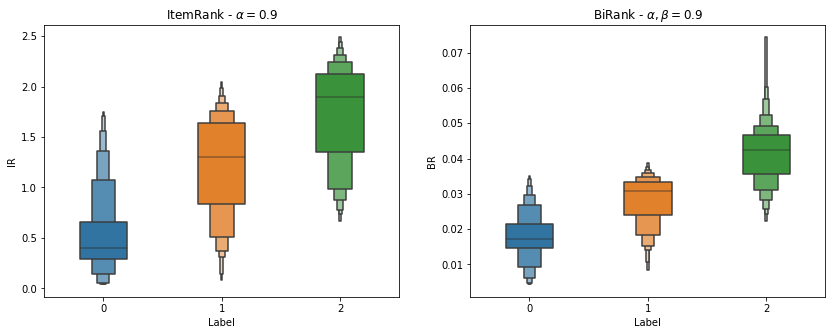

<function matplotlib.pyplot.tight_layout>

In [34]:
print('alpha is '+str(alpha))
plt.figure(figsize=(14, 5)) 

plt.subplot(1,2,1)
sns.boxenplot(x=df_Labeled['Label'], y=df_Labeled['IR'],showfliers = False, width=0.4)
plt.title('ItemRank - ' + r'$\alpha =$' + str(alpha))

plt.subplot(1,2,2)
sns.boxenplot(x=df_Labeled['Label'], y=df_Labeled['BR'],showfliers = False, width=0.4)
plt.title('BiRank - ' + r'$\alpha,\beta =$'+ str(alpha))

plt.show()
plt.tight_layout

In [35]:
random.seed(30)
df = shuffle(df_Labeled, random_state=0)
df

,StudentID,CourseCode,Label,IR,BR
481,Student88,2-EFM-238/17,0,0.870490,0.027965
52,Student3,2-EFM-102/15,1,1.707378,0.032893
269,Student17,2-PMS-116/19,1,1.827602,0.031980
229,Student15,2-EFM-215/17,1,1.213952,0.029308
386,Student25,2-EFM-119/15,2,1.429672,0.035705
...,...,...,...,...,...
833,Student15,2-EFM-238/17,0,1.315193,0.028335
577,Student37,2-EFM-103/00,2,2.342168,0.046808
181,Student51,2-EFM-236/15,0,0.479094,0.017980
329,Student7,2-MAT-114/15,0,0.012957,0.005173


# ML models

In [36]:
print(df.shape)
df2 = df.loc[df['Label'] != 2]
print(df2.shape)

(2378, 5)
(1578, 5)


In [37]:
print(len(df2.loc[df2['Label'] == 1]))
print(len(df2.loc[df2['Label'] == 0]))

673
905


In [ ]:
# # create X
# X = np.array(df2['IR']).reshape(-1, 1)
# X.shape

# create X
X = np.array(df2['BR']).reshape(-1, 1)
X.shape

# # create X
# X = np.array(df2[['IR','BR']])
# X.shape

# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)

(1578, 1)

In [39]:
# create y
y = np.array(df2['Label'])
y.shape

(1578,)

In [ ]:
# divide data into training and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=15, stratify=y)

print(X_train.shape)
print(X_test.shape)
# check for distribution of y
print(sum(y_train)/len(y_train))
print(sum(y_test)/len(y_test))

(1183, 1)
(395, 1)
0.4268808114961961
0.4253164556962025


## LR

In [ ]:
# Grid Search for optimal parameters with CV
# round1
parameter_grid = {
              'C': [0.01,0.1,1,10,25,50,75,100,200,500,1000,2000]
}

# round2
# parameter_grid = {
#               'C':[800,850,900,1000,1100]

# }

grid = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=parameter_grid,verbose=2, n_jobs=10, cv = 5
)

grid.fit(X_train, y_train)
print("Best accuracy: %f with params %s" % (grid.best_score_, grid.best_params_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.4s


Best accuracy: 0.774312 with params {'C': 75}


[Parallel(n_jobs=10)]: Done  60 out of  60 | elapsed:    5.8s finished


In [ ]:
# model training and fitting
model_LR = LogisticRegression(C =75)
model_LR.fit(X_train, y_train)
print("Traning accuracy for Linear Regression: {}".format(model_LR.score(X_train, y_train)))

Traning accuracy for Linear Regression: 0.7726120033812341


Test score 0.8202531645569621
Sensitivity = 0.7380952380952381
Specificity = 0.8810572687224669
Logistic Regression: ROC AUC = 0.883


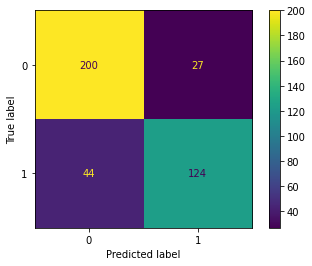

In [ ]:
# TEST DATA
# score
print('Test score '+str(model_LR.score(X_test, y_test) ))
# confusion matrix
plot_confusion_matrix(model_LR,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=['0','1'])

# Specificity and sensitivity
tn, fp, fn, tp = confusion_matrix(y_test, model_LR.predict(X_test)).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print('Sensitivity = '+str(sensitivity))
print('Specificity = '+str(specificity))

# ROC AUC
print('Logistic Regression: ROC AUC = %.3f' % (roc_auc_score(y_test, model_LR.predict_proba(X_test)[:, 1])))

## SVM

In [ ]:
# Grid Search for optimal parameters with CV
pipe_classifier = Pipeline([('scaler',  StandardScaler()),
            ('SVC', svm.SVC())])
parameter_grid = [{
              'SVC__C': [0.1, 0.5, 1], 
              'SVC__kernel': ['rbf', 'linear'],
              'SVC__gamma': [0.01,0.1,'auto',10]
}]


grid = GridSearchCV (estimator = pipe_classifier,
                               param_grid = parameter_grid,
                               scoring='roc_auc',cv = 5, verbose=2, n_jobs=10)
grid.fit(X_train, y_train)
print("Best score AUC: %f with params %s" % (grid.best_score_, grid.best_params_))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  22 tasks      | elapsed:    0.7s


Best score AUC: 0.831478 with params {'SVC__C': 0.1, 'SVC__gamma': 0.01, 'SVC__kernel': 'rbf'}


[Parallel(n_jobs=10)]: Done 120 out of 120 | elapsed:    2.5s finished


In [ ]:
# model training and fitting
svc = make_pipeline(StandardScaler(), svm.SVC(C=1, gamma = 0.01, kernel='rbf', probability=True))
svc.fit(X_train, y_train)
print("Traning accuracy for SVC: {}".format(svc.score(X_train, y_train)))

Traning accuracy for SVC: 0.7692307692307693


Testing accuracy for SVC: 0.8202531645569621
Sensitivity = 0.7797619047619048
Specificity = 0.8502202643171806
SVC: ROC AUC = 0.882


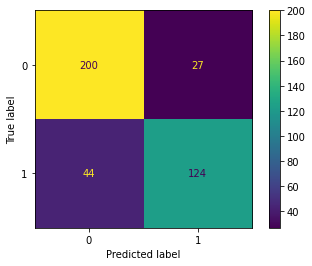

In [ ]:
# TEST DATA
# score
print('Testing accuracy for SVC: '+str(svc.score(X_test, y_test) ))
# confusion matrix
# confusion matrix
plot_confusion_matrix(model_LR,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=['0','1'])

# Specificity and sensitivity
tn, fp, fn, tp = confusion_matrix(y_test, svc.predict(X_test)).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print('Sensitivity = '+str(sensitivity))
print('Specificity = '+str(specificity))

# ROC AUC
print('SVC: ROC AUC = %.3f' % (roc_auc_score(y_test, svc.predict_proba(X_test)[:, 1])))

## RFC

In [ ]:
# Grid Search for optimal parameters with CV
# round1
parameter_grid = {
              'n_estimators': [10,25,50,75,100], 
              'max_depth': [1,2,3,4,5]
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=parameter_grid,
    scoring='roc_auc', verbose=2, n_jobs=10, cv = 5
)

grid.fit(X_train, y_train)
print("Best score AUC: %f with params %s" % (grid.best_score_, grid.best_params_))

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.3s


Best score AUC: 0.832917 with params {'max_depth': 2, 'n_estimators': 50}


[Parallel(n_jobs=10)]: Done 125 out of 125 | elapsed:   12.3s finished


In [ ]:
# training and fitting
rfc = RandomForestClassifier(n_estimators=100, max_depth=3)
rfc.fit(X_train, y_train)
print("Traning accuracy for Random Forest: {}".format(rfc.score(X_train, y_train)))

Traning accuracy for Random Forest: 0.8030431107354185


Testing accuracy for RFC: 0.8075949367088607
Sensitivity = 0.7380952380952381
Specificity = 0.8590308370044053
RFC: ROC AUC = 0.880


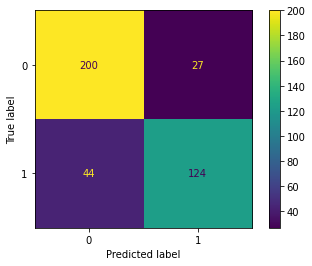

In [ ]:
# TEST DATA
# score
print('Testing accuracy for RFC: '+str(rfc.score(X_test, y_test) ))
# confusion matrix
plot_confusion_matrix(model_LR,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=['0','1'])

# Specificity and sensitivity
tn, fp, fn, tp = confusion_matrix(y_test, rfc.predict(X_test)).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print('Sensitivity = '+str(sensitivity))
print('Specificity = '+str(specificity))

# ROC AUC
print('RFC: ROC AUC = %.3f' % (roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1])))

## XGBOOST

In [ ]:
# Grid Search for optimal parameters with CV
# round1
parameter_grid = {
              'learning_rate': [0.1, 0.5, 1], 
              'max_depth': [2,3,4,5,6],
              'gamma': [0, 1, 5],
              'reg_lambda': [0, 1.0, 10.0],
}

grid = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=15,
                                ),
    param_grid=parameter_grid,
    scoring='roc_auc', verbose=2, n_jobs=10, cv = 5
)

grid.fit(X_train, y_train)
print("Best score AUC: %f with params %s" % (grid.best_score_, grid.best_params_))

Fitting 5 folds for each of 135 candidates, totalling 675 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    3.0s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:    8.0s
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:   15.9s
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:   26.3s


Best score AUC: 0.833362 with params {'gamma': 1, 'learning_rate': 1, 'max_depth': 3, 'reg_lambda': 10.0}


[Parallel(n_jobs=10)]: Done 675 out of 675 | elapsed:   28.0s finished


In [ ]:
# model training and fitting
xgbc = xgb.XGBClassifier(seed=15, objective='binary:logistic',                      
                            gamma=5, learning_rate=0.1, max_depth=2, reg_lambda=1.0)
xgbc.fit(X_train, y_train)
print("Traning accuracy for XGBoost: {}".format(xgbc.score(X_train, y_train)))

Traning accuracy for XGBoost: 0.775993237531699


Testing accuracy for RFC: 0.810126582278481
Sensitivity = 0.7023809523809523
Specificity = 0.8898678414096917
XGB: ROC AUC = 0.882


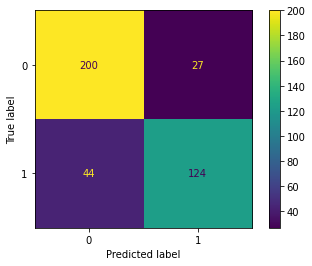

In [ ]:
# TEST DATA
# score
print('Testing accuracy for RFC: '+str(xgbc.score(X_test, y_test) ))
# confusion matrix
plot_confusion_matrix(model_LR,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=['0','1'])

# Specificity and sensitivity
tn, fp, fn, tp = confusion_matrix(y_test, xgbc.predict(X_test)).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print('Sensitivity = '+str(sensitivity))
print('Specificity = '+str(specificity))

# ROC AUC
print('XGB: ROC AUC = %.3f' % (roc_auc_score(y_test, xgbc.predict_proba(X_test)[:, 1])))

## Final Models

In [ ]:
# create y
y = np.array(df2['Label'])
y.shape

In [40]:
# all data
X = np.array(df2['IR']).reshape(-1, 1)
X.shape

# model training
model_IR = LogisticRegression(C = 10)
# Fit model
model_IR.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
# all data
X = np.array(df2['BR']).reshape(-1, 1)
X.shape

# model training
model_BR = LogisticRegression(C = 75)
# Fit model
model_BR.fit(X, y)

LogisticRegression(C=75, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Course recommendations

In [43]:
# Load data again
df_students = pd.read_csv('COURSES_data.csv', encoding='utf-16') 
df_subjects = df_students[['CourseName', 'CourseCode']].drop_duplicates()
print(df_subjects.shape)
df_students

(30, 2)


,CourseName,CourseCode,CourseRating,StudentID
0,Multivariate statistical analyses,2-EFM-151/15,4.12,Student0
1,Principles of mathematical modelling in scienc...,2-EFM-152/15,4.00,Student0
2,Modelling biological processes,2-EFM-236/15,4.11,Student0
3,Macroeconomic development and economic policie...,2-EFM-218/16,4.67,Student0
4,Time series analysis,2-EFM-102/15,4.59,Student0
...,...,...,...,...
1468,Integral transforms and special functions,2-MAT-114/15,4.83,Student94
1469,Modelling biological processes,2-EFM-236/15,4.50,Student94
1470,Digital signal processing,2-EFM-237/15,4.58,Student94
1471,Nonparametric statistic,2-PMS-212/15,4.80,Student94


Text(0.5, 1.0, 'Course popularity')

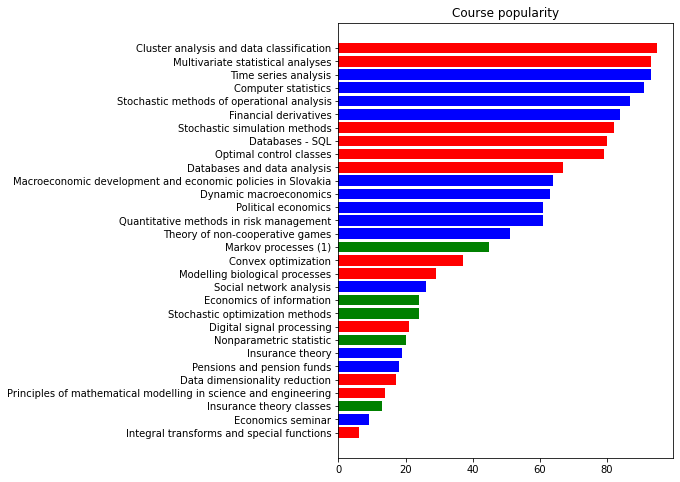

In [44]:
# enrollment distribution
data = df_students[['CourseName','StudentID']]
data = data.groupby(['CourseName']).size().reset_index(name='Count')
data.sort_values(by=['Count'], inplace=True)

names = list(data['CourseName'])
values = list(data['Count'])

plt.figure(figsize=(6, 8)) 
colors = ['red','red', 'blue', 'blue', 'blue', 'blue', 'red', 'red',
          'red', 'red', 'blue', 'blue', 'blue', 'blue', 'blue','green',
          'red', 'red', 'blue','green','green', 'red','green',
          'blue','blue', 'red', 'red','green', 'blue', 'red']
plt.barh(names, values, color= colors[::-1])
plt.title('Course popularity')

,NumberOfCourses,NumberOfStudents
0,1,1
1,5,1
2,7,17
3,8,34
4,9,42


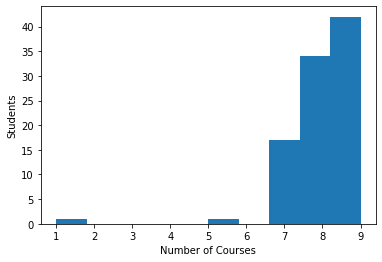

In [45]:
# Dominance of subjects
data2 = df_students[['CourseName','StudentID']].loc[df_students['CourseName'].isin(names[-9:])]
data2 = data2.drop_duplicates()
data2 = data2.groupby(['StudentID']).size().reset_index(name='NumberOfCourses')
plt.hist(data2['NumberOfCourses'])
plt.xlabel('Number of Courses')
plt.ylabel('Students')
data2.groupby(['NumberOfCourses']).size().reset_index(name='NumberOfStudents')

## Student selection

In [48]:
# FIRST EXAMPLE
# students name
name = ['Average Joe']
# students code
id = ['Student99']
# rating
rtg = 4

# subject until now
subjects = ['2-PMS-116/19','2-EFM-151/15','2-EFM-236/15','2-PMS-129/10', '2-EFM-147/15','2-EFM-215/17']
subjects2 = ['Cluster analysis and data classification','Multivariate statistical analyses', 'Modelling biological processes', 'Stochastic optimization methods', 'Optimal control classes','Quantitative methods in risk management']

In [56]:
# SECOND EXAMPLE
# students name
name = ['Plain Jane']
# students code
id = ['Student99']
# rating
rtg = 4

# subject until now
subjects = ['2-EFM-102/15','2-EFM-119/15','2-EFM-103/00','2-EFM-140/19', '2-PMS-129/10','2-EFM-215/17' ]
subjects2 = ['Time series analysis','Dynamic macroeconomics', 'Stochastic methods of operational analysis', 'Databases - SQL', 'Stochastic optimization methods','Quantitative methods in risk management']

After one is selected, add him to network

In [57]:
# create DF
df_P = pd.DataFrame()
df_P['StudentID'] = pd.Series([id[0] for x in range(len(subjects))])
df_P.insert(1, 'CourseCode', subjects)
df_P.insert(2, 'CourseRating', rtg)
df_P

,StudentID,CourseCode,CourseRating
0,Student99,2-EFM-102/15,4
1,Student99,2-EFM-119/15,4
2,Student99,2-EFM-103/00,4
3,Student99,2-EFM-140/19,4
4,Student99,2-PMS-129/10,4
5,Student99,2-EFM-215/17,4


In [58]:
# Concatenate dataframes
df_students = df_students[['StudentID' ,'CourseCode','CourseRating']]
df_new = pd.concat([df_P, df_students[['StudentID' ,'CourseCode','CourseRating']]])
df_new

,StudentID,CourseCode,CourseRating
0,Student99,2-EFM-102/15,4.00
1,Student99,2-EFM-119/15,4.00
2,Student99,2-EFM-103/00,4.00
3,Student99,2-EFM-140/19,4.00
4,Student99,2-PMS-129/10,4.00
...,...,...,...
1468,Student94,2-MAT-114/15,4.83
1469,Student94,2-EFM-236/15,4.50
1470,Student94,2-EFM-237/15,4.58
1471,Student94,2-PMS-212/15,4.80


## ItemRank based recommendation

In [59]:
#### Calculate ItemRank ####

# set hyper-parameter
alpha = 0.9

np_data = np.array(df_new)
print(np_data.shape)

# generate object
item_rank = ItemRank(np_data)
item_rank.generate_graph()
item_rank.generate_coef_from_graph()
print(item_rank.correlation_matrix.shape)

# calculate itemranks
IRs = []
DOAs = []
UserCounter = 0
user_name = 'Student99'
UserCounter +=  1
d = item_rank.generate_d(user_name=user_name)
IR = np.ones(len(item_rank.movie_names))
old_IR = IR
converged = False
counter = 0
while not converged:
  counter += 1
  old_IR = IR
  IR = item_rank.item_rank(alpha , IR , d)
  converged = (old_IR - IR < 0.0001).all()
IRs.append(IR)
np.array(IRs).shape

################################################################################
#### Insert into DataFrame ####
df_pred_IR = pd.DataFrame(np.transpose(IRs), columns=['IR'])
df_pred_IR['CourseCode'] =  item_rank.movie_names
# filter subject we have already enrolled to
df_pred_IR = df_pred_IR.loc[~df_pred_IR['CourseCode'].isin(subjects)]
df_pred_IR.shape

#### Make Prediction ####
# add probabilities from model
df_pred_IR['Prediction'] = model_IR.predict_proba(np.array(df_pred_IR['IR']).reshape(-1,1))[:,1]
# join names of subjects
df_pred_IR = df_pred_IR.join(df_subjects.set_index(['CourseCode']), on= ['CourseCode'], how='left')
#order by probability
df_pred_IR.sort_values(by='Prediction', ascending=False, inplace=True)
df_pred_IR

(1479, 3)
(30, 30)


,IR,CourseCode,Prediction,CourseName
0,1.385571,2-PMS-116/19,0.764314,Cluster analysis and data classification
10,1.340559,2-EFM-151/15,0.741416,Multivariate statistical analyses
16,1.328521,2-PMS-109/15,0.735052,Computer statistics
4,1.244499,2-EFM-106/15,0.687949,Financial derivatives
14,1.191337,2-PMS-123/10,0.655909,Stochastic simulation methods
13,1.143695,2-EFM-147/15,0.625927,Optimal control classes
25,0.976042,2-EFM-113/18,0.514031,Databases and data analysis
27,0.912545,2-EFM-238/17,0.470642,Political economics
15,0.904575,2-EFM-218/16,0.465213,Macroeconomic development and economic policie...
26,0.755937,2-EFM-105/00,0.366793,Theory of non-cooperative games


## BiRank based recommendation

In [60]:
#### Calculate BiRank ####

# set hyper-parameters
a = 0.9
b = 0.9

# Calculate Inputs
W, users, items =  gen_W(df_new['StudentID'], df_new['CourseCode'], df_new['CourseRating'])

# calculate Birank score
start_time = time.time()
BRs = []
DOAs = []
user_name = 'Student99'
UserCounter = users.tolist().index(user_name)
# set inital vector
v0 = (W.toarray()[UserCounter,:])/(W.toarray()[UserCounter,:].sum())
# calculate ranks of items for a user
u, v = birank(W, v0=v0, alpha=a, beta=b, max_iter=200, tol=0.0001, verbose=False)
BR = v
# append
BRs.append(BR)
np.array(BRs).shape

################################################################################
#### Insert into DataFrame ####
df_pred_BR = pd.DataFrame(np.transpose(BRs), columns=['BR'])
df_pred_BR['CourseCode'] =  items
# filter subject we have already enrolled to
df_pred_BR = df_pred_BR.loc[~df_pred_BR['CourseCode'].isin(subjects)]
df_pred_BR.shape

#### Make Prediction ####
# add probabilities from model
df_pred_BR['Prediction'] = model_BR.predict_proba(np.array(df_pred_BR['BR']).reshape(-1,1))[:,1]
# join names of subjects
df_pred_BR = df_pred_BR.join(df_subjects.set_index(['CourseCode']), on= ['CourseCode'], how='left')
#order by probability
df_pred_BR.sort_values(by='Prediction', ascending=False, inplace=True)
df_pred_BR

Shape of W: (96, 30)


,BR,CourseCode,Prediction,CourseName
12,0.036526,2-PMS-109/15,0.751262,Computer statistics
13,0.035199,2-PMS-116/19,0.724820,Cluster analysis and data classification
6,0.033376,2-EFM-151/15,0.685817,Multivariate statistical analyses
20,0.033295,2-PMS-123/10,0.684014,Stochastic simulation methods
10,0.033264,2-EFM-106/15,0.683334,Financial derivatives
11,0.030316,2-EFM-147/15,0.614263,Optimal control classes
15,0.029222,2-EFM-113/18,0.587219,Databases and data analysis
9,0.028874,2-EFM-218/16,0.578521,Macroeconomic development and economic policie...
16,0.027707,2-EFM-238/17,0.548932,Political economics
17,0.023807,2-EFM-105/00,0.448797,Theory of non-cooperative games


## Visualize

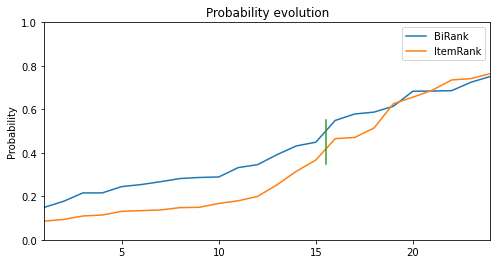

In [62]:
# plot probabilities
plt.figure(figsize=(8, 4)) 
x = np.arange(1, 25, 1)
y = df_pred_BR['Prediction'][::-1]
y2 = df_pred_IR['Prediction'][::-1]
plt.plot(x,y)
plt.plot(x,y2)
plt.plot([15.5, 15.5], [0.35, 0.55])
plt.ylim(0,1)
plt.xlim(1,24)
plt.ylabel('Probability')
plt.title('Probability evolution')
plt.legend(['BiRank','ItemRank'])